In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().resolve().parents[1]
sys.path.append(str(PROJECT_ROOT))
print("Loaded project root:", PROJECT_ROOT)

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from src.dataset import DeepPHQDataset, build_vocab, create_balanced_dataloader, split_by_pid
from models.lstm.lstm_model import DeepPHQLSTM 
import yaml


from models.text_cnn.utils import train, evaluate, set_seed, plot_curves
from models.text_cnn import TextCNN
from models.text_cnn import embeddings

# Load config
CONFIG_PATH = Path("cnn_config_curr.yaml") 

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

config

Loaded project root: C:\Users\wange\Documents\Classes\Deep Learning\DeepPHQ


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wange\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


{'data': {'level': 'sentence',
  'data_root': '../../data/processed',
  'word_csv': 'word_level.csv',
  'sentence_csv': 'sentence_level.csv',
  'dialogue_csv': 'dialogue_level.csv',
  'max_length': 512},
 'vocab': {'min_freq': 1, 'pad_token': '<PAD>', 'unk_token': '<UNK>'},
 'dataloader': {'batch_size': 64, 'num_workers': 2},
 'model': {'pretrained_embedding': False,
  'embeddings_file': 'glove_wiki50/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt',
  'embeddings_dim': 25,
  'num_filters': 16,
  'kernel_sizes': [4, 5, 10],
  'dropout': 0.1},
 'training': {'device': 'cuda',
  'num_epochs': 20,
  'learning_rate': '1e-3',
  'weight_decay': '1e-5',
  'gradient_clip': 2.0,
  'seed': 2025},
 'checkpoint': {'save_dir': '../../models/checkpoints',
  'filename': 'deepphq_cnn.pt'}}

In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are using device: %s" % device)

You are using device: cuda


In [3]:
data_cfg = config["data"]
root = Path(data_cfg["data_root"])

level = data_cfg["level"]

if level == "word":
    csv_path = root / data_cfg["word_csv"]
elif level == "sentence":
    csv_path = root / data_cfg["sentence_csv"]
elif level == "dialogue":
    csv_path = root / data_cfg["dialogue_csv"]
else:
    raise ValueError("Unknown level in config")

print("Loading:", csv_path)

df = pd.read_csv(csv_path)

all_texts = df["Text"].tolist()
vocab = build_vocab(all_texts, min_freq=config["vocab"]["min_freq"])

df.head()

Loading: ..\..\data\processed\sentence_level.csv
Vocab size = 8242


,PID,Text,PHQ_Score
0,300,um not atlanta georgia friendship cut them off...,2
1,300,two weeks ago can you be a little bit more spe...,2
2,300,interested can you be a little bit more specif...,2
3,300,repeat that congestion grandparents cut them o...,2
4,300,in the career field i love it less um no well ...,2


In [4]:
seed = config.get("training", {}).get("seed", 42)
set_seed(seed)
print(f"Seed set to {seed}")

# 1. split
train_df, val_df, test_df = split_by_pid(df)

# 2. create datasets
train_dataset = DeepPHQDataset(
    data=list(zip(train_df["PID"], train_df["Text"], train_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

val_dataset = DeepPHQDataset(
    data=list(zip(val_df["PID"], val_df["Text"], val_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)

test_dataset = DeepPHQDataset(
    data=list(zip(test_df["PID"], test_df["Text"], test_df["PHQ_Score"])),
    vocab=vocab,
    max_length=config["data"]["max_length"]
)



Seed set to 2025


In [57]:
# Fast ReLoad config for testing
CONFIG_PATH = Path("cnn_config_curr.yaml") 

with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

train_loader = create_balanced_dataloader(
    train_dataset,
    batch_size=config["dataloader"]["batch_size"]
)

val_loader = DataLoader(val_dataset, batch_size=config["dataloader"]["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config["dataloader"]["batch_size"], shuffle=False)

config

{'data': {'level': 'sentence',
  'data_root': '../../data/processed',
  'word_csv': 'word_level.csv',
  'sentence_csv': 'sentence_level.csv',
  'dialogue_csv': 'dialogue_level.csv',
  'max_length': 512},
 'vocab': {'min_freq': 1, 'pad_token': '<PAD>', 'unk_token': '<UNK>'},
 'dataloader': {'batch_size': 64, 'num_workers': 2},
 'model': {'pretrained_embedding': False,
  'embeddings_file': 'glove_wiki50/wiki_giga_2024_50_MFT20_vectors_seed_123_alpha_0.75_eta_0.075_combined.txt',
  'embeddings_dim': 100,
  'num_filters': 64,
  'kernel_sizes': [3, 5, 10],
  'dropout': 0.1},
 'training': {'device': 'cuda',
  'num_epochs': 10,
  'learning_rate': '2e-3',
  'weight_decay': '1e-5',
  'gradient_clip': 2.0,
  'seed': 2025},
 'checkpoint': {'save_dir': '../../models/checkpoints',
  'filename': 'deepphq_cnn.pt'}}

In [7]:

if config["model"]["pretrained_embedding"] == True:
    embeddings_file = config["model"]["embeddings_file"]
    embedding_matrix = embeddings.create_embedding_matrix(embeddings_file, vocab, config["model"]["embeddings_dim"])


In [58]:
model_config = config["model"]


if model_config["pretrained_embedding"] == True:
    cnn_model = TextCNN.CNNTextRegressor(len(vocab), embedding_dim = model_config["embeddings_dim"], kernel_sizes = model_config["kernel_sizes"], num_filters = model_config["num_filters"], dropout_rate = model_config["dropout"], pretrained_embedding = True, embedding_matrix = embedding_matrix, freeze_embeddings = False)
else:
    cnn_model = TextCNN.CNNTextRegressor(len(vocab), embedding_dim = model_config["embeddings_dim"], kernel_sizes = model_config["kernel_sizes"], num_filters = model_config["num_filters"], dropout_rate = model_config["dropout"], pretrained_embedding = False)


criterion = nn.MSELoss()  # Mean Squared Error for regression

optimizer = torch.optim.Adam(
    cnn_model.parameters(),
    lr=float(config["training"]["learning_rate"]),
    weight_decay=float(config["training"]["weight_decay"])
)

history = train(cnn_model, criterion, optimizer, train_loader, val_loader, epochs=config["training"]["num_epochs"], gradient_clip=config["training"]["gradient_clip"])
results = evaluate(cnn_model, test_loader)


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.75it/s]


Epoch 1/10
  Train Loss: 23.1199, Train MAE: 3.6859
  Val Loss: 48.5972, Val MAE: 6.8199
--------------------------------------------------


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.80it/s]


Epoch 2/10
  Train Loss: 5.1441, Train MAE: 1.5637
  Val Loss: 35.5318, Val MAE: 5.6705
--------------------------------------------------


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  7.06it/s]


Epoch 3/10
  Train Loss: 2.6771, Train MAE: 1.1564
  Val Loss: 30.2533, Val MAE: 5.0943
--------------------------------------------------


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  6.85it/s]


Epoch 4/10
  Train Loss: 2.0268, Train MAE: 1.0536
  Val Loss: 23.9462, Val MAE: 4.2810
--------------------------------------------------


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.81it/s]


Epoch 5/10
  Train Loss: 1.7629, Train MAE: 1.0128
  Val Loss: 23.0714, Val MAE: 4.1521
--------------------------------------------------


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.65it/s]


Epoch 6/10
  Train Loss: 1.6454, Train MAE: 1.0029
  Val Loss: 23.4129, Val MAE: 4.2106
--------------------------------------------------


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.79it/s]


Epoch 7/10
  Train Loss: 1.5021, Train MAE: 0.9578
  Val Loss: 21.9331, Val MAE: 3.9423
--------------------------------------------------


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:05<00:00,  6.88it/s]


Epoch 8/10
  Train Loss: 1.5229, Train MAE: 0.9615
  Val Loss: 23.0271, Val MAE: 4.1265
--------------------------------------------------


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.82it/s]


Epoch 9/10
  Train Loss: 1.3476, Train MAE: 0.9064
  Val Loss: 20.3895, Val MAE: 3.6528
--------------------------------------------------


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████| 41/41 [00:06<00:00,  6.63it/s]


Epoch 10/10
  Train Loss: 1.1986, Train MAE: 0.8558
  Val Loss: 20.5546, Val MAE: 3.6916
--------------------------------------------------
Loaded best model weights


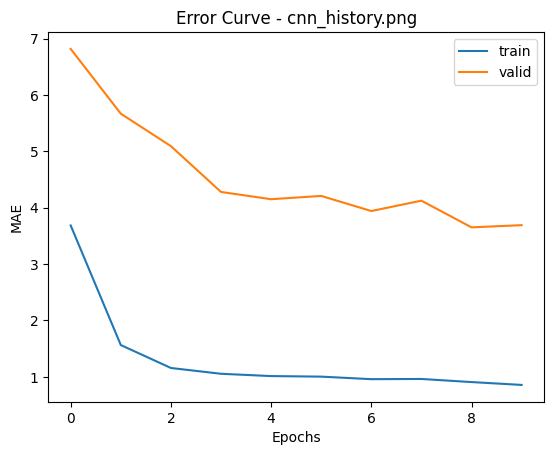

30.494531631469727 5.522185403576172 4.109358310699463 0.04584050178527832


In [59]:
results = evaluate(cnn_model, test_loader)
plot_curves(history["train_mae"], history["val_mae"], "cnn_history.png")
print(results["mse"], results["rmse"], results["mae"], results["r2"])